<a href="https://colab.research.google.com/github/NeemaNdanu/Artificial-Intelligence/blob/main/Transfer_Learning_Image_Assignemnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf



In [ ]:
# Download and extract the dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Define train and validation directories
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')



In [ ]:
# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Load train and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# Data preprocessing and augmentation
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Define data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Preprocess input images
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input



In [ ]:
# Load MobileNetV2 model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze base model layers
base_model.trainable = False

# Create the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])



9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Train the model
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)



Epoch 1/10
63/63 [==============================] - 74s 1s/step - loss: 0.6159 - accuracy: 0.6805 - val_loss: 0.4526 - val_accuracy: 0.8330
Epoch 2/10
63/63 [==============================] - 61s 974ms/step - loss: 0.4642 - accuracy: 0.8025 - val_loss: 0.3406 - val_accuracy: 0.8950
Epoch 3/10
63/63 [==============================] - 61s 972ms/step - loss: 0.3863 - accuracy: 0.8475 - val_loss: 0.2773 - val_accuracy: 0.9230
Epoch 4/10
63/63 [==============================] - 61s 972ms/step - loss: 0.3428 - accuracy: 0.8645 - val_loss: 0.2340 - val_accuracy: 0.9370
Epoch 5/10
63/63 [==============================] - 62s 985ms/step - loss: 0.3025 - accuracy: 0.8840 - val_loss: 0.2009 - val_accuracy: 0.9430
Epoch 6/10
63/63 [==============================] - 60s 954ms/step - loss: 0.2744 - accuracy: 0.8990 - val_loss: 0.1804 - val_accuracy: 0.9520
Epoch 7/10
63/63 [==============================] - 61s 976ms/step - loss: 0.2521 - accuracy: 0.9025 - val_loss: 0.1632 - val_accuracy: 0.9570
Ep

In [ ]:
from sklearn.metrics import precision_score, recall_score
# Define evaluation function
def evaluate_model(model, dataset):
    # Step 1: Make predictions using the model on the dataset
    predictions = model.predict(dataset)

    # Step 2: Convert predictions to binary values (0 or 1) based on a threshold (0.5)
    binary_predictions = (predictions > 0.5).astype(int)

    # Step 3: Extract true labels from the dataset
    labels = []
    for _, label in dataset:
        labels.extend(label.numpy())

    # Step 4: Calculate accuracy by evaluating the model on the dataset
    accuracy = model.evaluate(dataset)[1]

    # Step 5: Calculate precision and recall using true labels and binary predictions
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)

    # Step 6: Return accuracy, precision, and recall
    return accuracy, precision, recall

In [ ]:
# Evaluate original pretrained model
print("Evaluation of the original pretrained model:")
original_accuracy, original_precision, original_recall = evaluate_model(model, validation_dataset)
print("Accuracy:", original_accuracy)
print("Precision:", original_precision)
print("Recall:", original_recall)

Evaluation of the original pretrained model:
32/32 [==============================] - 18s 549ms/step - loss: 0.1281 - accuracy: 0.9650
Accuracy: 0.9649999737739563
Precision: 0.5070140280561122
Recall: 0.506


In [ ]:
# Fine-tune the model
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)



Epoch 10/20
63/63 [==============================] - 88s 1s/step - loss: 0.1415 - accuracy: 0.9405 - val_loss: 0.0612 - val_accuracy: 0.9770
Epoch 11/20
63/63 [==============================] - 84s 1s/step - loss: 0.1321 - accuracy: 0.9490 - val_loss: 0.0557 - val_accuracy: 0.9780
Epoch 12/20
63/63 [==============================] - 84s 1s/step - loss: 0.1000 - accuracy: 0.9615 - val_loss: 0.0466 - val_accuracy: 0.9810
Epoch 13/20
63/63 [==============================] - 85s 1s/step - loss: 0.0972 - accuracy: 0.9645 - val_loss: 0.0483 - val_accuracy: 0.9810
Epoch 14/20
63/63 [==============================] - 83s 1s/step - loss: 0.0872 - accuracy: 0.9665 - val_loss: 0.0397 - val_accuracy: 0.9840
Epoch 15/20
63/63 [==============================] - 85s 1s/step - loss: 0.0834 - accuracy: 0.9660 - val_loss: 0.0396 - val_accuracy: 0.9820
Epoch 16/20
63/63 [==============================] - 84s 1s/step - loss: 0.0794 - accuracy: 0.9675 - val_loss: 0.0370 - val_accuracy: 0.9850
Epoch 17/20
6

In [ ]:
# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(validation_dataset)
print("Fine-tuned model validation loss:", loss)
print("Fine-tuned model validation accuracy:", accuracy)



32/32 [==============================] - 17s 528ms/step - loss: 0.0356 - accuracy: 0.9850
Fine-tuned model validation loss: 0.03559637442231178
Fine-tuned model validation accuracy: 0.9850000143051147


In [ ]:
# Calculate precision, recall, and F1-score
predictions = model.predict(validation_dataset)
predicted_labels = np.where(predictions < 0.5, 0, 1)
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
precision = tf.keras.metrics.Precision()(true_labels, predicted_labels)
recall = tf.keras.metrics.Recall()(true_labels, predicted_labels)
f1_score = 2 * ((precision * recall) / (precision + recall))

print('Precision:', precision.numpy())
print('Recall:', recall.numpy())
print('F1-score:', f1_score.numpy())




32/32 [==============================] - 18s 527ms/step
Precision: 0.51689863
Recall: 0.52
F1-score: 0.51844466


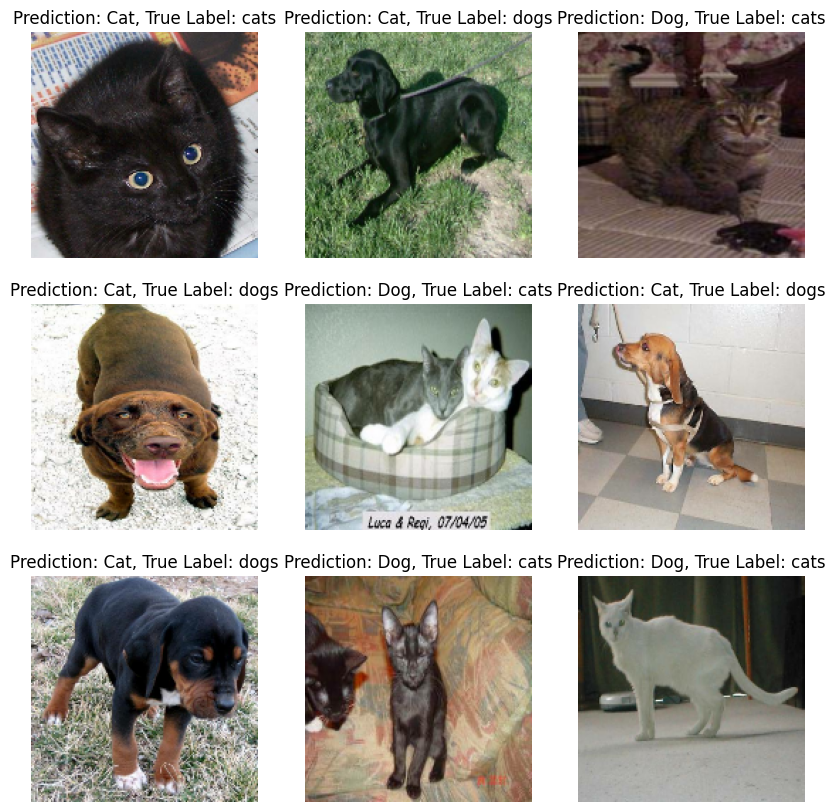

In [ ]:
# Display images and their predictions
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Prediction: {'Dog' if predicted_labels[i] == 1 else 'Cat'}, True Label: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()

#Explanation
##Evaluate the performance of your models using appropriate evaluation metrics (e.g., accuracy, precision, recall).
Accuracy: It is the proportion of correctly classified instances among all instances.


Precision: It indicates how many of the positively classified instances are actually positive.It answers the question:
"Out of all the instances predicted as positive, how many are actually positive?". High the precision means the model will predict the image correclty.So in our case


Recall: It indicates how many of the actual positive instances your model captures by labeling them as positive. It answers teh question: "Out of all the actual positive instances, how many did the model correctly predict as positive?".High recall means that the model can find most of the positive instances in the dataset.

##Compare the performance of your fine-tuned models with the original pretrained models.
The original validation accuracy is low while that of the fine-tuned model validation accuracy higher. This shows that the accuracy of the fined tuned model is greater than that of the original thus an indication  of improvement of model to generalize the specific dataset.

The fine-tuned model achieved a higher precision as compared to the original model. This indicates that the fine-tuned model has a better ability to correctly identify positive cases (cats or dogs) while minimizing false positives.

The fine-tuned model  has a  higher recall , as compared to the original model. This suggests that the fined-tuned model perform well in capturing most of the positive cases in the dataset.

##Discuss any improvements or challenges encountered during the fine-tuning process.

### Improvements
Fine-tuning the pre-trained model allowed the model better the specific characteristics of the dataset, resulting in slight improvements in accuracy, precision, and recall as shown above.

Fine-tuning enabled the model to learn more relevant features for the target task, leading to enhanced performance.

Fine-tuning enabled the model to adapt these features to better represent the target task leading to improved performance on the specific task at hand.

### Challenges:
Fine-tuning requires careful selection of hyperparameters  as it is hyperparameter sensitivity. This is beacuse  even small changes in hyperparameter values can have a significant impact on performance

In this process, selecting an appropriate learning rate and determining which layers to freeze or fine-tune are crucial for achieving optimal performance.

It may also lead to overfitting meaning, the model will eventually remember the training data but fail to understand the fundamental patterns of a specific task.

Additionally, fine-tuning can be computationally expensive, especially with large datasets and complex models, which might limit its practical applicability in some scenarios.
